# Exploration of Principal Component Analysis and Factor Analysis
### Author: Mazen Alalwan
### Mentor: Michael Pyrcz, Associate Professor, University of Texas at Austin

### Introduction:
The goal of this Jupyter notebook is to offer an environment to experiment with Principal Component Analysis and Factor Analysis on synthetic data. A synthetic dataset makes the most sense for this project because it gives the user total control. By providing a few sliders to shape the dataset, the user can gain a more intuitive understanding of how various variables influence dimensionality-reduction techniques, namely, Principal Component Analysis and Factor Analysis.


### Quick overview of PCA & FA:
The problem with high dimensional data are numerous and includes high computational cost, overfitting(curse of dimensionality), storage space, and much more. Both PCA and Factor are widely used techinques for dimenseionality reduction. 

#### Principal Component Analysis(PCA): 
It computes the eigen values and orthogonal(uncorrelated) eigen eigenvectors of the covariance matrix and maximizes the eigen values. The technique involved in PCA is purely mathmetical and involves projection, primarily. It is reasnaoble to think of it as "shifting” the axes in a way that ensures one axis captures the maximum possible variance(main essence). This is really helpful because it means we can compose variables(PC’s) out of multiple variables and capture as much variance as we can through an algorithm. For more in depth overview, I suggeset checking this link: https://geostatsguy.github.io/MachineLearningDemos_Book/MachineLearning_PCA.html

#### Factor Analysis(FA):
Assumes that observed variables are linear combinations of hidden latent factors plus some error and attempts to uncover these factors.

![Picture of Factor Analysis Equation](./Factor_Analysis_Equation.png "Optional title")


For a more mathmetically vigorous dive, check out: 
https://stats.oarc.ucla.edu/spss/seminars/introduction-to-factor-analysis/a-practical-introduction-to-factor-analysis/

## Synthetic Dataset "Lab"

The benfit of having a synthetic dataset is that you know everything there is to know about the data. This gets rid of one "mystery" of many different variables while trying to investigate dimensionality-reduction techniques. The dataset we are synthesizing in this notebook is a basic linear dataset with a few adjustable parameters that will be explained below.

The dataset is generated through linear combination of a randomly generated latent matrix multiplied by a sparse random weight vector:

![Picture of Linear Combination](./Linear_Combination.png "Optional title")


The latent matrix is drawn from a gaussian distribution and the weight vector is randomly generated with a chosen density of non-zero values. This process creates a synthetic dataset that has "key" or "important" latent factors that contributes to the linearality of our dataset.

### Sliders:
These are the parameters that we can control in our dataset. For readability purposes, I have left out the explanation of how each parameter is coded within the comments before each line. 
#### Number of samples:
Controls the number of synthetic samples. A datapoint is a row in our dataset.

#### Number of K latents:
Controls the number of latent variables(k) or "features". It is important to note that each time the user selects a different value for this slider, a whole different set of latent variables are generated. For example, if we have 10 latent variable, and we change it to 11, that is not just an exta latent variable added to the same dataset. Instead, that is 11 new latent variables(fresh start).

#### Density:
This sets the sparsity of zeroes in the loading matrix. Higher density means less zeros thus more features have "weight" on the target. You will notice that if you change this setting to 1, all the features will have a linear relationship with the target.

#### Noise std:
Noise standard deviation is added to the target value by multiplying a fraction(Noise std value that you choose) with randomly generated numbers drawn from a standard distribution(range = [-1, 1]). Each target value gets a different noise value.

#### Known Features(Available in the model training section only):
This is the number of features that we can use in training the model. It is also the number of features we use when applying both PCA and FA. You can think of it as "available" or "visible" features.

#### rho strength:
This controls how the features correlates with each other. Note: this is correlation between features, NOT features with target. 

In [1]:
# reproducibility cell
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
import time, warnings
import numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition   import PCA, FactorAnalysis
from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing   import StandardScaler
from ipywidgets              import IntSlider, FloatSlider
from numpy.random import default_rng

In [3]:
def make_corr_matrix(k, rho):
    # k×k matrix with 1s on the diagonal and rho on off-diagonals.
    R = np.full((k, k), rho)
    
    # We fill the diagonal with 1 beceause each feature should have a 1 correlation with itself.
    np.fill_diagonal(R, 1.0)
    return R

# returns np.ndarray
def make_Z(n_samples, k_latent, rho, rng=None):
    """Return n_samples × k_latent standard-normal features with corr = rho."""
    R = make_corr_matrix(k_latent, rho)
    
    #  "L is the Cholesky factor of R ”  that just means L × Lᵀ = R in matrix jargon
    L = np.linalg.cholesky(R) 
    
    # Creates a numpy array with numbers drawn from a normal distrbiution
    Z_raw = rng.standard_normal((n_samples, k_latent)) # The numbers in this array are still indepdent
    
    
    return Z_raw @ L.T

In [4]:
import matplotlib.pyplot as plt, numpy as np
import ipywidgets as w
from ipywidgets import IntSlider, FloatSlider, interactive_output
from sklearn.preprocessing import StandardScaler
from numpy.random import default_rng

def generate_and_plot(n_samples=800, k_latent=10, rho_strength=0.5,
                      density=0.10, noise_std=0.05, outlier_pct=0.0):

    rng = default_rng(123)
    Z   = make_Z(n_samples, k_latent, rho_strength, rng)  # latent factors

    # build sparse weight vector and target
    
    # all zeros
    w = np.zeros(k_latent)
    
    # Select random positions and replace them with random number from 0 to 1 (weights)
    w[rng.choice(k_latent, int(density * k_latent), replace=False)] = rng.random(int(density * k_latent))
    
    # create a target from the latent variables and inject noise
    y = Z @ w + noise_std * rng.standard_normal(n_samples)

    # observed features = all k_latent columns
    Xs = StandardScaler().fit_transform(Z)

    # stopped here
    if outlier_pct:
        n_out = int(outlier_pct * n_samples)
        rows  = rng.choice(n_samples, n_out, replace=False)
        Xs[rows] += rng.normal(0, 3, size=(n_out, k_latent))

    # grid of “feature j vs y” scatter-plots 
    n_feats = k_latent
    ncol    = min(2, n_feats)               # up to 4 plots per row
    nrow    = int(np.ceil(n_feats / ncol))

    fig, axes = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                             constrained_layout=True)
    axes = np.atleast_2d(axes).ravel()      # flatten even for 1 row

    for j in range(n_feats):
        ax = axes[j]
        ax.scatter(Xs[:, j], y, s=22, alpha=0.8, edgecolors='k')
        ax.set_xlabel(f'Feature {j+1} (scaled)')
        ax.set_ylabel('Target y')
        ax.set_title(f'F{j+1} vs y')
        ax.grid(alpha=.3)

    # hide unused sub-axes (when k_latent % ncol ≠ 0)
    for k in range(n_feats, len(axes)):
        axes[k].set_visible(False)

    fig.suptitle(f'{n_samples} × {k_latent} synthetic dataset — all features vs target', fontsize=14)
    plt.show()


# sliders
common = dict(layout=w.Layout(width='300px'), continuous_update=False)

n_samples    = w.IntSlider(value=800, min=100, max=5000, step=100,
                           description='Number of samples', **common)
k_latent     = w.IntSlider(value=10,  min=2,   max=20,  step=1,
                           description='K latent', **common)
rho_strength = w.FloatSlider(value=0.5, min=0.0, max=0.9, step=0.05,
                             description='Rho strength', **common)
density      = w.FloatSlider(value=0.10, min=0.01, max=1.0, step=0.01,
                             description='Density', **common)
noise_std    = w.FloatSlider(value=0.05, min=0.0,  max=0.5, step=0.01,
                             description='Noise std', **common)
outlier_pct  = w.FloatSlider(value=0.00, min=0.0,  max=0.20, step=0.01,
                             description='Outlier pct', **common)

# align label widths
for s in (n_samples, k_latent, rho_strength, density, noise_std, outlier_pct):
    s.style.description_width = '150px'

# layout sliders
ui = w.GridBox(
    children=[n_samples, k_latent, rho_strength,
              density, noise_std, outlier_pct],
    layout=w.Layout(grid_template_columns='repeat(2, 300px)',
                    grid_gap='8px 16px')
)

# wire sliders to existing function
out = interactive_output(generate_and_plot, {
    'n_samples': n_samples,
    'k_latent': k_latent,
    'rho_strength': rho_strength,
    'density': density,
    'noise_std': noise_std,
    'outlier_pct': outlier_pct
})

display(ui, out)

GridBox(children=(IntSlider(value=800, continuous_update=False, description='Number of samples', layout=Layout…

Output()

# Linear regression fit
The cell below takes the synthetic data we created above and trains a linear regression model on it after reducing it using both PCA and FA.

### Sliders:
The sliders are the same we used in showcasing the data but we are adding an extra one for known features. This slider controls how much features that are accessible to us to stimulate real life scenarios where not all the variables are meassured or known.


### Graphs

#### R^2 vs Dimensionality : 
This graph compares the R^2 scores when training the linear regression model on our linear synthetic dataset after reducing it using Prinical Component Analysis and Factor Analysis. On the legend, you can how many components/factor/feature is needed for an R^2 score of 0.80. We are performing k-fold cross-validation with a k value of 5.

#### Computation Cost: 
This meassures the cumulative fit time that is taken between reducing the data and fitting the linear regression model. In this specific case, we get the same output pattern with all settings: Factor Analysis takes the longest computation time, while uncompressed takes the least. 

#### Dimensionality reduction efficency: 
This calculates cumulative variance ratio of the components with the original full dataset variance(all original features). For Factor Analysis, we calculate cumulative communality.

#### Empirical covariance: 
the covariance matrix is calculated using np.cov(Xs) where Xs is the known or "visible" features.

#### PCA and FA loadings: 
The two heat maps shows the "loadings" or "weights" each features has on a component. 

GridBox(children=(IntSlider(value=800, continuous_update=False, description='Number of samples', layout=Layout…

Output()

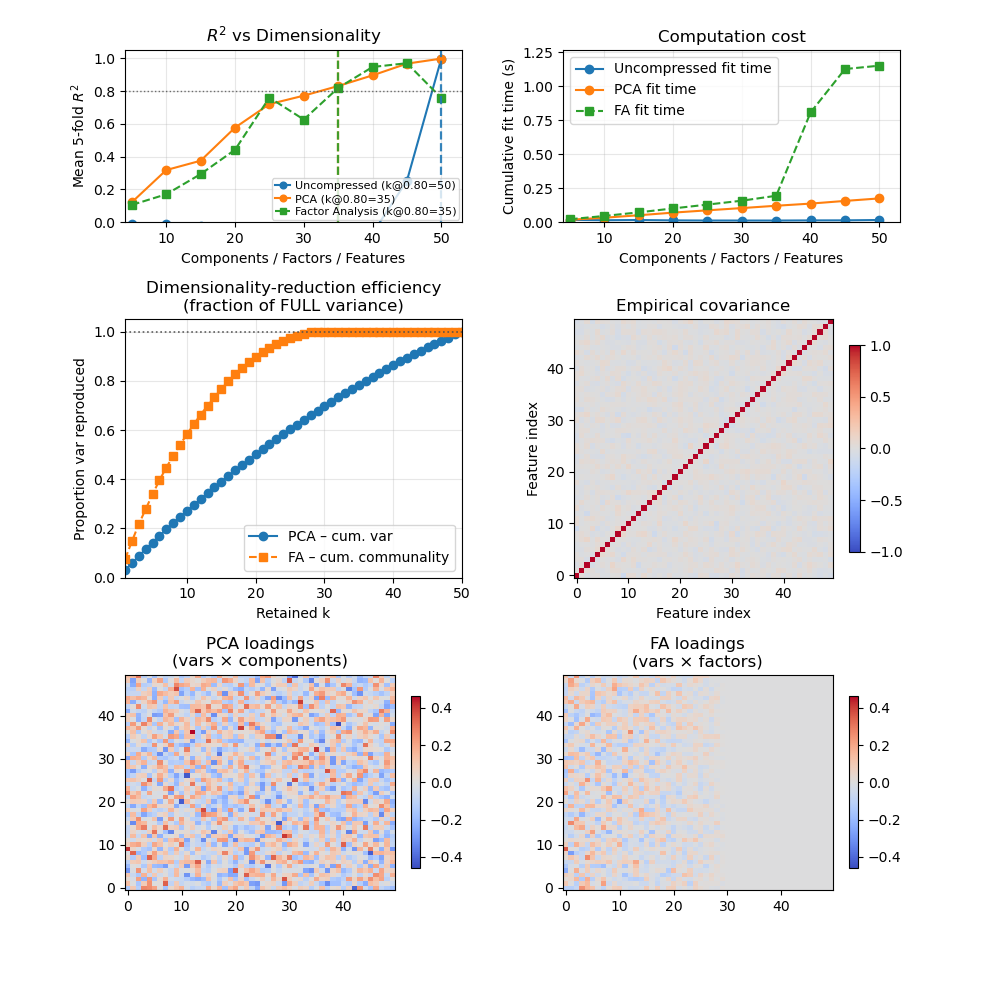

In [8]:
%matplotlib widget        

# Imports 
import ipywidgets as w
import time, warnings
import numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition   import PCA, FactorAnalysis
from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing   import StandardScaler
from ipywidgets              import IntSlider, FloatSlider, interactive_output
from numpy.random            import default_rng

warnings.filterwarnings("ignore")

# Global constants
K_GRID = list(range(5, 100, 5))      # k = 5, 10, …, 95


def one_run(k_vals, n_samples, k_latent, density, noise_std,
            known_feats, rho_strength=0.9, outlier_pct=0.0):
    rng = default_rng(42)

    # latent factors + response
    Z      = make_Z(n_samples, k_latent, rho_strength, rng)
    w      = np.zeros(k_latent)
    idx    = rng.choice(k_latent, int(density * k_latent), replace=False)
    w[idx] = rng.random(len(idx))
    y      = Z @ w + noise_std * rng.standard_normal(n_samples)

    X_full = Z
    X      = Z[:, :known_feats]
    Xs     = StandardScaler().fit_transform(X)
    
    if outlier_pct:
        n_out = int(outlier_pct * n_samples)
        rows  = rng.choice(n_samples, n_out, replace=False)
        outliers = rng.normal(0, 3, size=(n_out, k_latent))
        Xs[rows] += outliers
        X_full[rows] += outliers

    cv  = KFold(n_splits=5, shuffle=True, random_state=0)
    clf = LinearRegression()

    unc_r2, pca_r2, fa_r2 = [], [], []
    unc_t , pca_t , fa_t  = [], [], []

    for k in k_vals:
        # baseline
        t0 = time.perf_counter()
        unc_r2.append(cross_val_score(clf, X[:, :k], y, cv=cv, scoring='r2').mean())
        unc_t.append(time.perf_counter() - t0)

        # PCA
        t0  = time.perf_counter()
        Zp  = PCA(n_components=k, random_state=0).fit_transform(Xs)
        pca_r2.append(cross_val_score(clf, Zp, y, cv=cv, scoring='r2').mean())
        pca_t.append(time.perf_counter() - t0)

        # FA
        t0  = time.perf_counter()
        Zf  = FactorAnalysis(n_components=k, random_state=0).fit_transform(Xs)
        fa_r2.append(cross_val_score(clf, Zf, y, cv=cv, scoring='r2').mean())
        fa_t.append(time.perf_counter() - t0)

    return (np.array(unc_r2), np.array(pca_r2), np.array(fa_r2),
            np.array(unc_t),  np.cumsum(pca_t), np.cumsum(fa_t),
            Xs, X_full)

# Build the figure
fig = plt.figure(figsize=(10, 10), constrained_layout=False)

# 3 rows × 2 cols; give the middle row (heat‑maps) extra height
gs = fig.add_gridspec(3, 2, height_ratios=[0.8, 1.2, 1.0])

fig.subplots_adjust(hspace=0.45, wspace=0.30, top=0.95)

# row 0
ax_r2   = fig.add_subplot(gs[0, 0])
ax_time = fig.add_subplot(gs[0, 1])

# row 1
ax_eff  = fig.add_subplot(gs[1, 0])
ax_cov  = fig.add_subplot(gs[1, 1])

# row 2 – loadings heat‑maps
ax_loads_pca = fig.add_subplot(gs[2, 0])
ax_loads_fa  = fig.add_subplot(gs[2, 1])

# initialise line plots 
line_unc, = ax_r2.plot([], [], 'o-',  label='Uncompressed')
line_pca, = ax_r2.plot([], [], 'o-',  label='PCA')
line_fa , = ax_r2.plot([], [], 's--', label='Factor Analysis')
ax_r2.set(xlabel='Components / Factors / Features',
          ylabel='Mean 5‑fold $R^2$', title='$R^2$ vs Dimensionality')
ax_r2.grid(alpha=.3); ax_r2.legend()

line_unct , = ax_time.plot([], [], 'o-',  label='Uncompressed fit time')
line_pt    , = ax_time.plot([], [], 'o-',  label='PCA fit time')
line_fat   , = ax_time.plot([], [], 's--', label='FA fit time')
ax_time.set(xlabel='Components / Factors / Features',
            ylabel='Cumulative fit time (s)', title='Computation cost')
ax_time.grid(alpha=.3); ax_time.legend()

line_pca_eff, = ax_eff.plot([], [], 'o-',  label='PCA – cum. var')
line_fa_eff , = ax_eff.plot([], [], 's--', label='FA – cum. communality')
ax_eff.set(xlabel='Retained k', ylabel='Proportion var reproduced',
           title='Dimensionality‑reduction efficiency', ylim=(0,1.05))
ax_eff.grid(alpha=.3); ax_eff.legend()

# initialise heat‑maps with dummy data
cov_img       = ax_cov.imshow(np.zeros((5, 5)), vmin=-1, vmax=1,
                              cmap='coolwarm', origin='lower')
load_img_pca  = ax_loads_pca.imshow(np.zeros((5, 5)), vmin=-1, vmax=1,
                                    cmap='coolwarm', origin='lower')
load_img_fa   = ax_loads_fa .imshow(np.zeros((5, 5)), vmin=-1, vmax=1,
                                    cmap='coolwarm', origin='lower')

fig.colorbar(cov_img,      ax=ax_cov,       shrink=0.8)
fig.colorbar(load_img_pca, ax=ax_loads_pca, shrink=0.8)
fig.colorbar(load_img_fa,  ax=ax_loads_fa,  shrink=0.8)

ax_cov.set_title('Empirical covariance')
ax_cov.set(xlabel='Feature index', ylabel='Feature index')

ax_loads_pca.set_title('PCA loadings\n(vars × components)')
ax_loads_fa .set_title('FA loadings\n(vars × factors)')

# Interactive update 
def update(n_samples=1000, k_latent=50, density=0.10,
           noise_std=0.05, known_feats=50, rho_strength=0.5, outlier_pct=0.0):

    k_vals = [k for k in K_GRID if k <= known_feats]
    if not k_vals:
        return

    unc_r2, pca_r2, fa_r2, unc_t, pca_t, fa_t, Xs, X_full = one_run(
        k_vals, n_samples, k_latent, density, noise_std,
        known_feats, rho_strength=rho_strength, outlier_pct=outlier_pct)

    # R² 
    line_unc.set_data(k_vals, unc_r2)
    line_pca.set_data(k_vals, pca_r2)
    line_fa .set_data(k_vals, fa_r2)
    ax_r2.set_xlim(min(k_vals) - 1, max(k_vals) + 3)
    ax_r2.set_ylim(0, 1.05)

    # timing 
    line_unct.set_data(k_vals, unc_t)
    line_pt  .set_data(k_vals, pca_t)
    line_fat .set_data(k_vals, fa_t)
    ax_time.set_xlim(min(k_vals) - 1, max(k_vals) + 3)
    ax_time.set_ylim(0, max(max(pca_t), max(fa_t)) * 1.10)

    # covariance heat‑map -
    cov = np.cov(Xs, rowvar=False)
    cov_img.set_data(cov)
    cov_img.set_extent([-0.5, known_feats-0.5, -0.5, known_feats-0.5])
    ax_cov.set_xlim(-0.5, known_feats-0.5)
    ax_cov.set_ylim(-0.5, known_feats-0.5)
    ax_cov.set_aspect('equal', adjustable='box')

    # efficiency curves 
    k_axis = np.arange(1, known_feats + 1)

    # variance of full latent set vs known subset (use same ddof as sklearn)
    total_var_full  = np.var(X_full, axis=0, ddof=1).sum()   # all k_latent features
    total_var_known = np.var(X_full[:, :known_feats], axis=0, ddof=1).sum()
    cap_ratio = total_var_known / total_var_full             # ≤ 1; shows what’s even possible

    # PCA on standardized known features
    pca_sub = PCA(n_components=known_feats, random_state=0).fit(Xs)
    # explained_variance_ratio_ sums to 1 over the known subset → scale to FULL set
    cum_var_ratio_full = np.cumsum(pca_sub.explained_variance_ratio_) * cap_ratio
    line_pca_eff.set_data(k_axis, np.clip(cum_var_ratio_full, 0, 1))

    # FA: variance explained
    fa_sub = FactorAnalysis(n_components=known_feats, random_state=0).fit(Xs)
    var_by_factor = (fa_sub.components_**2).sum(axis=1)              # shape (known_feats,)
    cum_comm_ratio_full = np.cumsum(var_by_factor) / var_by_factor.sum() * cap_ratio
    line_fa_eff.set_data(k_axis, np.clip(cum_comm_ratio_full, 0, 1))

    ax_eff.set_xlim(1, known_feats)
    ax_eff.set_ylim(0, 1.05)
    ax_eff.set_title('Dimensionality-reduction efficiency\n(fraction of FULL variance)')

    # draw/update a horizontal “cap” line at the attainable fraction
    for art in getattr(ax_eff, "_cap_art", []):
        try: art.remove()
        except Exception: pass
    ax_eff._cap_art = [ax_eff.axhline(cap_ratio, ls=":", lw=1.2, color="0.3", alpha=0.9)]


    # PCA loadings heat‑map 
    load_mat_pca = pca_sub.components_.T # The reason we tranpose is so that the rows become features in the heat map
    load_img_pca.set_data(load_mat_pca)

    # FA loadings heat‑map 
    load_mat_fa  = fa_sub.components_.T # The reason we tranpose is so that the rows become features in the heat map
    load_img_fa.set_data(load_mat_fa)

    # common colour scale (symmetric)
    vmax = max(np.abs(load_mat_pca).max(), np.abs(load_mat_fa).max())
    for img in (load_img_pca, load_img_fa):
        img.set_clim(-vmax, vmax)

    # set extents / axes for both loadings plots
    for ax_loads, mat in [(ax_loads_pca, load_mat_pca),
                          (ax_loads_fa , load_mat_fa )]:
        n_feat, n_comp = mat.shape
        ax_loads.images[0].set_extent([-0.5, n_comp-0.5, -0.5, n_feat-0.5])
        ax_loads.set_xlim(-0.5, n_comp-0.5)
        ax_loads.set_ylim(-0.5, n_feat-0.5)
        ax_loads.set_aspect('auto')
  
    # clear old artifacts
    for art in getattr(ax_r2, "_r80_art", []):
        try: art.remove()
        except Exception: pass
    ax_r2._r80_art = []

    # horizontal reference
    ax_r2._r80_art.append(ax_r2.axhline(0.80, ls=":", lw=1, color="0.3", alpha=0.8))

    def k_at_080(r2_vals):
        vals = np.asarray(r2_vals)
        idx = np.where(vals >= 0.80)[0]
        return k_vals[idx[0]] if idx.size else None

    k_unc = k_at_080(unc_r2)
    k_pca = k_at_080(pca_r2)
    k_fa  = k_at_080(fa_r2)

    # vertical lines only (no text on the plot)
    def vline_if(k_star, color):
        if k_star is None: return
        ax_r2._r80_art.append(ax_r2.axvline(k_star, ls="--", lw=1.6, color=color, alpha=0.9))

    vline_if(k_unc, line_unc.get_color())
    vline_if(k_pca, line_pca.get_color())
    vline_if(k_fa , line_fa.get_color())

    # put k info into legend labels
    def lbl(name, k):
        return f"{name} (k@0.80={k})" if k is not None else f"{name} (k@0.80=–)"
    line_unc.set_label(lbl("Uncompressed",   k_unc))
    line_pca.set_label(lbl("PCA",            k_pca))
    line_fa .set_label(lbl("Factor Analysis",k_fa))
    ax_r2.legend(loc="lower right", frameon=True)
    
    # Adjust legend size
    leg = ax_r2.legend(
    loc="lower right",
    frameon=True,
    fontsize=8,         # smaller text
    markerscale=0.8,    # smaller marker size in legend
    handlelength=1.4,   # shorter line samples
    handletextpad=0.4,  # tighter text spacing
    labelspacing=0.25,  # tighter between rows
    borderpad=0.25,     # tighter frame padding
    borderaxespad=0.25  # closer to axes
)

    fig.canvas.draw_idle()

#Sliders
common = dict(layout=w.Layout(width='300px'), continuous_update=False)

n_samples    = w.IntSlider(800,  min=200, max=5000, step=50,  description='Number of samples', **common)
k_latent     = w.IntSlider(50,   min=10,  max=200,  step=1,   description='K latent',          **common)
density      = w.FloatSlider(0.10, min=0.01, max=1.0, step=0.01, description='Density',        **common)
noise_std    = w.FloatSlider(0.05, min=0.00, max=1.0, step=0.01, description='Noise std',      **common)
known_feats  = w.IntSlider(50,    min=5,   max=100,  step=5,   description='Known features',      **common)
rho_strength = w.FloatSlider(0.00, min=0.0, max=0.9, step=0.01, description='Rho strength',    **common)
outlier_pct  = w.FloatSlider(0.00, min=0.0, max=0.20, step=0.01, description='Outlier pct',    **common)

# align label widths
for s in (n_samples, k_latent, density, noise_std, known_feats, rho_strength, outlier_pct):
    s.style.description_width = '150px'

# 3-column grid layout
ui = w.GridBox(
    children=[n_samples, k_latent, rho_strength,
              density, noise_std, known_feats,
              outlier_pct],
    layout=w.Layout(grid_template_columns='repeat(3, 300px)', grid_gap='8px 16px')
)


out = interactive_output(update, {
    'n_samples': n_samples,
    'k_latent': k_latent,
    'density': density,
    'noise_std': noise_std,
    'known_feats': known_feats,
    'rho_strength': rho_strength,
    'outlier_pct': outlier_pct
})

display(ui, out)


### Comments:

#### About me: 
My name is Mazen Alalwan, and I'm an senior student studying Petroleum Engineering at the University of Texas at Austin. I have made this project during summer as a final demonstration of what I have learned during a two month period under the mentorship of Professor Michael Pyrcz.

Through this project, I hope that I have benfited anyone who liked to learn more about synthetic datasets, Factor Analysis, and Principal Component Analysis. If you would like to reach out to me for any reason regarding the project, feel free to email me at: mazen.alalwan@utexas.edu